<a href="https://colab.research.google.com/github/rtakimoto/flight_delay/blob/main/tree/main/api/MachineLearning/notebooks/SmallFlightDelay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Geracao de Modelo para analise de atraso de voo
Instalando as bibliotecas

Bibliotecas necessárias

In [1]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import os
#import kagglehub
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

#Carregamento do dataset (carga de um dataset pequeno para o MVP da PUC)



In [2]:
# Informa a URL de importação do dataset
# DatasetPath = kagglehub.dataset_download("eminhashimi/flight-delay-dataset")
# print("Path to dataset files:", DatasetPath)

In [3]:
FlightDataset = pd.read_csv("flights_test.csv", delimiter=',')
# displaying the contents of the Test XLSX file
FlightDataset.head()

,id,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME
0,0,2015,6,1,1,NK,298,N616NK,LAS,IAH,...,17.0,159.0,170.0,175.0,149.0,1222.0,628.0,9.0,500.0,637.0
1,1,2015,6,1,1,AA,1230,N3EPAA,SEA,DFW,...,12.0,35.0,235.0,232.0,217.0,1660.0,612.0,3.0,610.0,615.0
2,2,2015,6,1,1,DL,2044,N6701,ANC,SLC,...,11.0,22.0,277.0,280.0,261.0,2125.0,643.0,8.0,652.0,651.0
3,3,2015,6,1,1,US,448,N151UW,SLC,CLT,...,12.0,16.0,232.0,221.0,202.0,1727.0,538.0,7.0,607.0,545.0
4,4,2015,6,1,1,F9,1126,N214FR,LAS,IAD,...,13.0,30.0,270.0,271.0,250.0,2065.0,740.0,8.0,745.0,748.0


##Pre Processamento do dataset carregado

In [4]:
FlightDataset.info()

# Remove rows with null values
FlightDatasetCleaned = FlightDataset.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492847 entries, 0 to 492846
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   492847 non-null  int64  
 1   YEAR                 492847 non-null  int64  
 2   MONTH                492847 non-null  int64  
 3   DAY                  492847 non-null  int64  
 4   DAY_OF_WEEK          492847 non-null  int64  
 5   AIRLINE              492847 non-null  object 
 6   FLIGHT_NUMBER        492847 non-null  int64  
 7   TAIL_NUMBER          492847 non-null  object 
 8   ORIGIN_AIRPORT       492847 non-null  object 
 9   DESTINATION_AIRPORT  492847 non-null  object 
 10  SCHEDULED_DEPARTURE  492847 non-null  float64
 11  DEPARTURE_TIME       492847 non-null  float64
 12  DEPARTURE_DELAY      492847 non-null  float64
 13  TAXI_OUT             492847 non-null  float64
 14  WHEELS_OFF           492847 non-null  float64
 15  SCHEDULED_TIME   

In [5]:
print('Shape of the resulting Flight Dataset table: ', FlightDataset.shape)
print('Shape of the resulting Flight Dataset table: ', FlightDatasetCleaned.shape)

Shape of the resulting Flight Dataset table:  (492847, 23)
Shape of the resulting Flight Dataset table:  (492847, 23)


In [6]:
FlightDatasetCleaned['DELAY_DETECTED'] = 0
FlightDatasetCleaned.loc[(FlightDatasetCleaned['ARRIVAL_TIME']-FlightDatasetCleaned['SCHEDULED_ARRIVAL']) >0, 'DELAY_DETECTED'] = 1
FlightDatasetCleaned.head()

,id,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,DELAY_DETECTED
0,0,2015,6,1,1,NK,298,N616NK,LAS,IAH,...,159.0,170.0,175.0,149.0,1222.0,628.0,9.0,500.0,637.0,1
1,1,2015,6,1,1,AA,1230,N3EPAA,SEA,DFW,...,35.0,235.0,232.0,217.0,1660.0,612.0,3.0,610.0,615.0,1
2,2,2015,6,1,1,DL,2044,N6701,ANC,SLC,...,22.0,277.0,280.0,261.0,2125.0,643.0,8.0,652.0,651.0,0
3,3,2015,6,1,1,US,448,N151UW,SLC,CLT,...,16.0,232.0,221.0,202.0,1727.0,538.0,7.0,607.0,545.0,0
4,4,2015,6,1,1,F9,1126,N214FR,LAS,IAD,...,30.0,270.0,271.0,250.0,2065.0,740.0,8.0,745.0,748.0,1


##Diminuição do número de registros para o MVP da PUC

In [7]:
FlightDatasetCleaned = FlightDatasetCleaned.sample(frac=0.02)
print('Shape of the resulting Flight Dataset table: ', FlightDatasetCleaned.shape)
FlightDatasetCleaned.head()

Shape of the resulting Flight Dataset table:  (9857, 24)


,id,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,DELAY_DETECTED
378044,378044,2015,6,24,3,DL,750,N966AT,BOS,JFK,...,614.0,80.0,74.0,41.0,187.0,655.0,16.0,720.0,711.0,0
363382,363382,2015,6,23,2,EV,5030,N730EV,ATL,HPN,...,748.0,138.0,135.0,114.0,780.0,942.0,4.0,954.0,946.0,0
143390,143390,2015,6,9,2,OO,5243,N965SW,DAY,ORD,...,1741.0,76.0,65.0,45.0,240.0,1726.0,8.0,1741.0,1734.0,0
25236,25236,2015,6,2,2,AA,357,N3AXAA,DFW,SAT,...,1421.0,73.0,64.0,40.0,247.0,1501.0,5.0,1513.0,1506.0,0
278975,278975,2015,6,18,4,WN,1645,N432WN,LAS,LAX,...,531.0,65.0,57.0,40.0,236.0,611.0,9.0,635.0,620.0,0


In [8]:
airline_names = FlightDatasetCleaned['AIRLINE'].unique()
tail_names = FlightDatasetCleaned['TAIL_NUMBER'].unique()
origin_names = FlightDatasetCleaned['ORIGIN_AIRPORT'].unique()
destination_names = FlightDatasetCleaned['DESTINATION_AIRPORT'].unique()

str_cols = FlightDatasetCleaned.columns[FlightDatasetCleaned.columns.str.contains('(?:AIRLINE|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT)')]
clfs = {c:LabelEncoder() for c in str_cols}

for col, clf in clfs.items():
  FlightDatasetCleaned[col] = clfs[col].fit_transform(FlightDatasetCleaned[col])

airline_values = FlightDatasetCleaned['AIRLINE'].unique()
tail_values = FlightDatasetCleaned['TAIL_NUMBER'].unique()
origin_values = FlightDatasetCleaned['ORIGIN_AIRPORT'].unique()
destination_values = FlightDatasetCleaned['DESTINATION_AIRPORT'].unique()

FlightDatasetCleaned.head()

,id,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,DELAY_DETECTED
378044,378044,2015,6,24,3,3,750,3478,36,134,...,614.0,80.0,74.0,41.0,187.0,655.0,16.0,720.0,711.0,0
363382,363382,2015,6,23,2,4,5030,2372,19,116,...,748.0,138.0,135.0,114.0,780.0,942.0,4.0,954.0,946.0,0
143390,143390,2015,6,9,2,9,5243,3476,72,191,...,1741.0,76.0,65.0,45.0,240.0,1726.0,8.0,1741.0,1734.0,0
25236,25236,2015,6,2,2,0,357,911,76,227,...,1421.0,73.0,64.0,40.0,247.0,1501.0,5.0,1513.0,1506.0,0
278975,278975,2015,6,18,4,13,1645,1166,151,144,...,531.0,65.0,57.0,40.0,236.0,611.0,9.0,635.0,620.0,0


In [9]:
map_airline = np.array([airline_names, airline_values])
column_names = ['AIRLINE', 'VALUES']
airline_dataframe = pd.DataFrame(map_airline.transpose(), columns=column_names)
print(airline_dataframe)

map_tail = np.array([tail_names, tail_values])
column_names = ['TAIL_NUMBER', 'VALUES']
tail_dataframe = pd.DataFrame(map_tail.transpose(), columns=column_names)
print(tail_dataframe)

map_origin = np.array([origin_names, origin_values])
column_names = ['ORIGIN_AIRPORT', 'VALUES']
origin_dataframe = pd.DataFrame(map_origin.transpose(), columns=column_names)
print(origin_dataframe)

map_destination = np.array([destination_names, destination_values])
column_names = ['DESTINATION_AIRPORT', 'VALUES']
destination_dataframe = pd.DataFrame(map_destination.transpose(), columns=column_names)
print(destination_dataframe)

# Define o path
directory = 'data'

#Salvando os mapeamentos
if not os.path.exists(directory):
  os.makedirs(directory)

airline_dataframe.to_csv(os.path.join(directory, 'airline.csv'), index=False)
tail_dataframe.to_csv(os.path.join(directory, 'tail.csv'), index=False)
origin_dataframe.to_csv(os.path.join(directory, 'origin.csv'), index=False)
destination_dataframe.to_csv(os.path.join(directory, 'destination.csv'), index=False)


#print(clfs['AIRLINE'].inverse_transform(FlightDatasetCleaned['AIRLINE']))


   AIRLINE VALUES
0       DL      3
1       EV      4
2       OO      9
3       AA      0
4       WN     13
5       MQ      7
6       UA     10
7       B6      2
8       US     11
9       AS      1
10      HA      6
11      VX     12
12      NK      8
13      F9      5
     TAIL_NUMBER VALUES
0         N966AT   3478
1         N730EV   2372
2         N965SW   3476
3         N3AXAA    911
4         N432WN   1166
...          ...    ...
3551      N802DN   2702
3552      N413UA   1119
3553      N426AA   1149
3554      N3LGAA   1063
3555      N124US    100

[3556 rows x 2 columns]
    ORIGIN_AIRPORT VALUES
0              BOS     36
1              ATL     19
2              DAY     72
3              DFW     76
4              LAS    151
..             ...    ...
279            DVL     83
280            SJT    250
281            BQK     38
282            MFR    174
283            TXK    275

[284 rows x 2 columns]
    DESTINATION_AIRPORT VALUES
0                   JFK    134
1                  

# Separação em conjunto de treino e conjunto de teste com holdout

In [10]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = FlightDatasetCleaned.values
X = FlightDatasetCleaned[['DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DEPARTURE_DELAY', 'SCHEDULED_ARRIVAL']].values
y = FlightDatasetCleaned['DELAY_DETECTED'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

#Modelagem e Inferência
Criação e avaliação de modelos

LR: 0.764107 (0.012151)
KNN: 0.585543 (0.015588)
CART: 0.726571 (0.011827)
NB: 0.689537 (0.005419)
SVM: 0.614709 (0.006331)
Bagging: 0.809511 (0.012113)
RF: 0.814583 (0.013588)
ET: 0.804944 (0.011541)
Ada: 0.804438 (0.008427)
GB: 0.816358 (0.010334)
Voting: 0.764616 (0.008663)


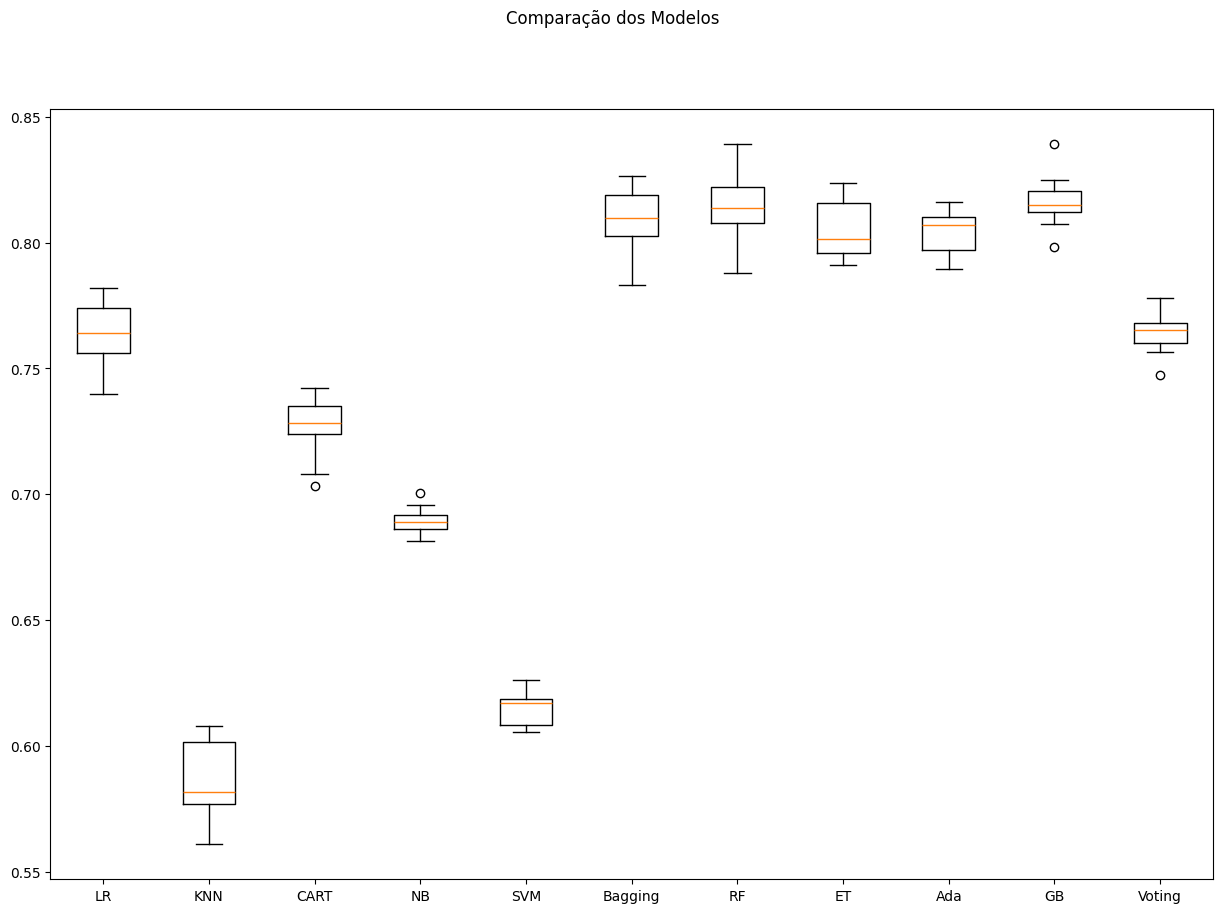

In [11]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos (treinamento)
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Criação e avaliação de modelos: dados padronizados e normalizados

Trabalhando com dados pontencialmente desbalanceados ou sensíveis a escala

StandardScaler (padronização do conjunto de dados) e MinMaxScaler (normalização do conjunto de dados) são duas técnicas de normalização/escala usadas em machine learning para pré-processamento de dados e são úteis para preparar dados para algoritmos de aprendizado de máquina que são sensíveis à escala dos dados.

## StandardScaler
StandardScaler padroniza os dados, ou seja, remove a média e escala os dados para que tenham uma variância unitária. Ele transforma os dados para que a média de cada feature seja 0 e a variância seja 1.

Fórmula: $z_i=\frac{x_i-\mu}{\sigma}$


onde:
- $x_i$ é o valor original do $i$-ésimo termo da feature.
- $\mu$ é a média dos valores da feature.
- $\sigma$ é o desvio padrão dos valores da feature.
𝑥
x é o valor original da feature.
𝜇
μ é a média dos valores da feature.
𝜎
σ é o desvio padrão dos valores da feature.


## MinMaxScaler
MinMaxScaler escala e transforma os dados para um intervalo específico, geralmente entre 0 e 1. Ele transforma os dados para que o menor valor de uma feature seja 0 e o maior valor seja 1.

Fórmula: $z_i=\frac{x_i-min(x)}{max(x)-min(x)}$

onde:
- $x_i$ é o valor original do $i$-ésimo termo da feature.
- $min(x)$ é o menor valor da feature.
- $max(x)$ é o maior valor da feature.

Nós vamos aplicar essas técnicas para os dados do dataset de diabetes através da construção de pipelines. Pipelines são uma maneira de simplificar o processo de construção de modelos, permitindo que você execute várias etapas de pré-processamento e modelagem em sequência.

LR-orig: 0.764 (0.012)
KNN-orig: 0.586 (0.016)
CART-orig: 0.727 (0.012)
NB-orig: 0.690 (0.005)
SVM-orig: 0.615 (0.006)
Bag-orig: 0.810 (0.012)
RF-orig: 0.815 (0.014)
ET-orig: 0.805 (0.012)
Ada-orig: 0.804 (0.008)
GB-orig: 0.816 (0.010)
Vot-orig: 0.765 (0.009)
LR-padr: 0.763 (0.012)
KNN-padr: 0.698 (0.011)
CART-padr: 0.728 (0.013)
NB-padr: 0.690 (0.005)
SVM-padr: 0.800 (0.013)
Bag-padr: 0.808 (0.012)
RF-padr: 0.815 (0.013)
ET-padr: 0.807 (0.011)
Ada-padr: 0.804 (0.009)
GB-padr: 0.816 (0.010)
Vot-padr: 0.793 (0.014)
LR-norm: 0.726 (0.008)
KNN-norm: 0.601 (0.018)
CART-norm: 0.725 (0.011)
NB-norm: 0.690 (0.005)
SVM-norm: 0.721 (0.007)
Bag-norm: 0.810 (0.014)
RF-norm: 0.816 (0.012)
ET-norm: 0.805 (0.013)
Ada-norm: 0.804 (0.008)
GB-norm: 0.816 (0.010)
Vot-norm: 0.737 (0.007)


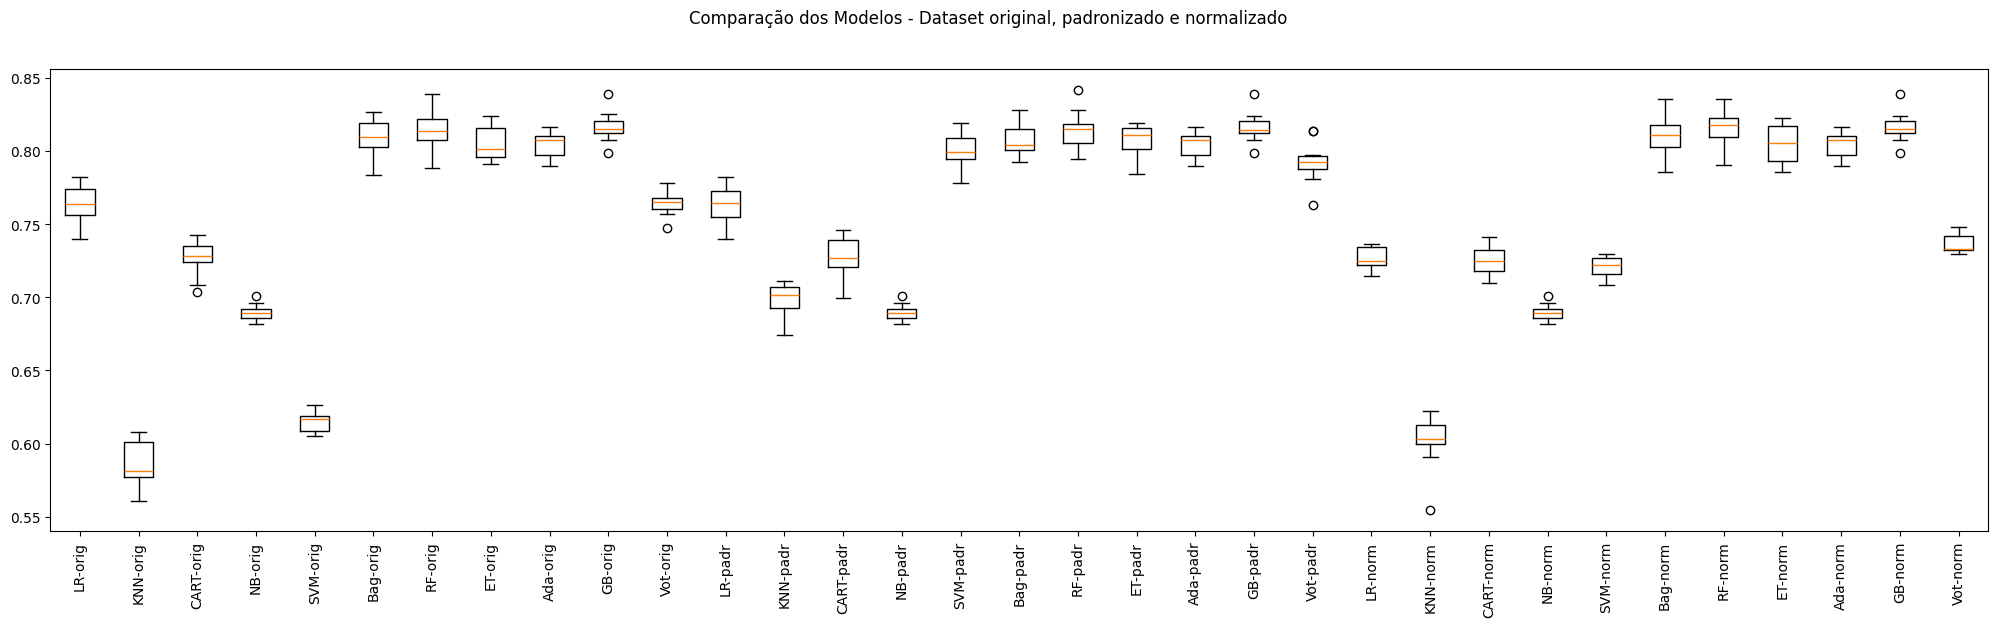

In [12]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines
# A ordem de execução é da esquerda para a direita.

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset original, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

# Otimização dos hiperparâmetros

A otimização de hiperparâmetros é o processo de encontrar os valores ideais para os hiperparâmetros de um modelo de machine learning. O objetivo é encontrar a combinação de hiperparâmetros que resulta no melhor desempenho do modelo.


## Grid Search (*força bruta*)

Como Funciona o Grid Search?
1. Definição do Espaço de Hiperparâmetros: Primeiro, define-se um conjunto de valores possíveis para cada hiperparâmetro.
2. Avaliação das Combinações: Em seguida, cada combinação possível desses valores é avaliada.
3. Seleção do Melhor Conjunto: A combinação de hiperparâmetros que produz o melhor desempenho é selecionada.

In [ ]:
np.random.seed(7)  # Definindo uma semente global para este bloco

# Lista de modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(estimators=bases, voting='hard')))

# Definindo os componentes do pipeline
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Lista de pipelines
pipelines = []

# Criando pipelines para cada modelo
for name, model in models:
    pipelines.append((name + '-orig', Pipeline(steps=[(name, model)])))
    pipelines.append((name + '-padr', Pipeline(steps=[standard_scaler, (name, model)])))
    pipelines.append((name + '-norm', Pipeline(steps=[min_max_scaler, (name, model)])))

# Definindo os parâmetros para GridSearchCV
param_grids = {
    'LR': {
        'LR__C': [0.01, 0.1, 1, 10, 100],
        'LR__solver': ['liblinear', 'saga']
    },
    'KNN': {
        'KNN__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
        'KNN__metric': ["euclidean", "manhattan", "minkowski"]
    },
    'CART': {
        'CART__max_depth': [None, 10, 20, 30, 40, 50],
        'CART__min_samples_split': [2, 5, 10],
        'CART__min_samples_leaf': [1, 2, 4]
    },
    'NB': {
        'NB__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    'SVM': {
        'SVM__C': [0.1, 1, 10, 100],
        #'SVM__C': [1, 10],
        'SVM__gamma': [1, 0.1, 0.01, 0.001],
        #'SVM__gamma': [1, 0.1],
        'SVM__kernel': ['rbf', 'linear']
    },
    'RF': {
        'RF__n_estimators': [10, 50, 100, 200],
        'RF__max_features': ['auto', 'sqrt', 'log2'],
        'RF__max_depth': [None, 10, 20, 30],
        'RF__min_samples_split': [2, 5, 10],
        'RF__min_samples_leaf': [1, 2, 4]
    },
    'ET': {
        'ET__n_estimators': [10, 50, 100, 200],
        'ET__max_features': ['auto', 'sqrt', 'log2'],
        'ET__max_depth': [None, 10, 20, 30],
        'ET__min_samples_split': [2, 5, 10],
        'ET__min_samples_leaf': [1, 2, 4]
    },
    'Ada': {
        'Ada__n_estimators': [10, 50, 100, 200],
        'Ada__learning_rate': [0.01, 0.1, 1, 10]
    },
    'GB': {
        'GB__n_estimators': [10, 50, 100, 200],
        'GB__learning_rate': [0.01, 0.1, 0.2, 0.3],
        'GB__max_depth': [3, 5, 7, 9]
    },
    'Voting': {
        # Para VotingClassifier, geralmente não há hiperparâmetros para ajustar diretamente
        # Ajustar os hiperparâmetros dos estimadores base individualmente se necessário
    }
}

# Parâmetros de cross-validation e scoring
scoring = 'accuracy'
kfold = 5

# Executando o GridSearchCV para cada pipeline
for name, pipeline in pipelines:
    model_type = name.split('-')[0]
    if model_type in param_grids:
        param_grid = param_grids[model_type]
    else:
        param_grid = {}  # Para modelos que não têm parâmetros definidos

    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # Imprimindo a melhor configuração
    print("Modelo: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Modelo: LR-orig - Melhor: 0.763475 usando {'LR__C': 0.01, 'LR__solver': 'liblinear'}
Modelo: LR-padr - Melhor: 0.762587 usando {'LR__C': 10, 'LR__solver': 'saga'}
Modelo: LR-norm - Melhor: 0.761446 usando {'LR__C': 100, 'LR__solver': 'liblinear'}
Modelo: KNN-orig - Melhor: 0.627901 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 19}
Modelo: KNN-padr - Melhor: 0.728091 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 17}
Modelo: KNN-norm - Melhor: 0.647812 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 19}
Modelo: CART-orig - Melhor: 0.795561 usando {'CART__max_depth': 10, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 2}
Modelo: CART-padr - Melhor: 0.794166 usando {'CART__max_depth': 10, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 5}
Modelo: CART-norm - Melhor: 0.793278 usando {'CART__max_depth': 10, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 2}
Modelo: NB-orig - Melhor: 0.688776 usando {'NB__var_smoothing': 1e-07}
Modelo: NB-pa

In [ ]:
# Tuning do KNN

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

# Finalização do Modelo

In [ ]:
# Avaliação do modelo com o conjunto de testes
# Melhor modelo
# Modelo: GB-norm - Melhor: 0.823716 usando {'GB__learning_rate': 0.1, 'GB__max_depth': 3, 'GB__n_estimators': 50}

np.random.seed(7)

# Preparação do modelo
scaler = MinMaxScaler().fit(X_train)
rescaledX = scaler.transform(X_train) # aplicação da normalização no conjunto de treino
#model = RandomForestClassifier(n_estimators=100,
#                               max_features='sqrt',
#                               min_samples_split=5,
#                               max_depth=20,
#                               min_samples_leaf=1)
#model = GradientBoostingClassifier(n_estimators=50,
#                               learning_rate=0.1,
#                               max_depth=3)
#model = LogisticRegression(C=100,
#                           solver='liblinear')
model = KNeighborsClassifier(n_neighbors=21,
                           metric='manhattan')
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da normalização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

### Rodando o modelo a partir de um pipeline com os hiperparâmetros otimizados.

In [ ]:
np.random.seed(7)

#model = RandomForestClassifier(n_estimators=50,
#                               max_features='sqrt',
#                               min_samples_split=2,
#                               max_depth=10,
#                               min_samples_leaf=1)
#model = GradientBoostingClassifier(n_estimators=50,
#                               learning_rate=0.1,
#                               max_depth=3)
#model = LogisticRegression(C=100,
#                           solver='liblinear')
model = KNeighborsClassifier(n_neighbors=21,
                           metric='manhattan')

pipeline = Pipeline(steps=[('MinMaxScaler', MinMaxScaler()), ('RF', model)])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
print(accuracy_score(y_test, predictions))

### Salvando os arquivos

In [ ]:
# Define o path
directory = 'models'

#Salvando os mapeamentos
if not os.path.exists(directory):
  os.makedirs(directory)

# Salvando o modelo
#model_filename = 'rf_flights_classifier.pkl'
#model_filename = 'gb_flights_classifier.pkl'
#model_filename = 'flights_lr.pkl'
model_filename = 'flights_knn.pkl'
with open(os.path.join(directory, model_filename), 'wb') as file:
    pickle.dump(model, file)

# Define o path
directory = 'scalers'

#Salvando os mapeamentos
if not os.path.exists(directory):
  os.makedirs(directory)

# Salvando o scaler
scaler_filename = 'minmax_scaler_flights.pkl'
with open(os.path.join(directory, scaler_filename), 'wb') as file:
    pickle.dump(scaler, file)

# Define o path
directory = 'pipelines'

#Salvando os mapeamentos
if not os.path.exists(directory):
  os.makedirs(directory)

# Salvando o pipeline
#pipeline_filename = 'gb_flights_pipeline.pkl'
pipeline_filename = 'rf_flights_pipeline.pkl'
with open(os.path.join(directory, pipeline_filename), 'wb') as file:
    pickle.dump(pipeline, file)

# Salvando X_test e y_test
column_names = ['DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DEPARTURE_DELAY', 'SCHEDULED_ARRIVAL']
X_test_df = pd.DataFrame(X_test, columns=column_names)
column_names = ['DELAY_DETECTED']
y_test_df = pd.DataFrame(y_test, columns=column_names)
test_dataset_flights_df = pd.concat([X_test_df, y_test_df], axis=1)

# Define o path
directory = 'data'

#Salvando os mapeamentos
if not os.path.exists(directory):
  os.makedirs(directory)

X_test_df.to_csv(os.path.join(directory, "X_test_dataset_flights.csv"), index=False)
y_test_df.to_csv(os.path.join(directory, "y_test_dataset_flights.csv"), index=False)
test_dataset_flights_df.to_csv(os.path.join(directory, "test_dataset_flights.csv"), index=False)

## Simulando a aplicação do modelo em dados não vistos

In [ ]:
# Preparação do modelo com TODO o dataset
scaler = MinMaxScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da normalização com TODO o dataset
model.fit(rescaledX, y)

In [ ]:
# Novos dados - não sabemos a classe!
data = {'day':  [1, 12, 18],
        'week': [1, 4, 6],
        'airline': [3, 5, 10],
        'flight_no': [100, 500, 800],
        'tail': [500, 1500, 2000],
        'origin': [50, 100, 200],
        'destination': [80, 120, 210],
        'dep_delay': [5, -8, 12],
        'schedule_arrival': [415, 1309, 1845],
        }

atributos = ['day', 'week', 'airline', 'flight_no', 'tail', 'origin', 'destination', 'dep_delay', 'schedule_arrival']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:9].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

In [ ]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

#Max e Min

In [ ]:
print("Max")
print(test_dataset_flights_df.max())
print("Min")
print(test_dataset_flights_df.min())